In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint, solve_ivp

In [2]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_geometries as gij
import b_spin_ops as su2
import c_maxent_tools as me

In [143]:
params={}

params['size']=6
params['beta']=1.

params['omega']=.5*np.pi*2.; 

params['Jx']=5*10**-1*params['omega']; params['Jy'] = .75*params['Jx']; params['Jz']=.5*params['Jx']; params['chain_type']='XY'

In [144]:
spin_ops=su2.one_body_spin_ops(args=params)

idop=spin_ops['idop']
sx_total=sum(sx for sx in spin_ops['sx'])
sy_total=sum(sx for sx in spin_ops['sy'])
sz_total=sum(sx for sx in spin_ops['sz'])

In [145]:
H0=params['omega']*sz_total
Hint=1.*su2.Heisenberg_1D_Hamiltonian(spin_ops=spin_ops, args=params)
HXYZ=H0+Hint
vLR=max(params['Jx'], params['Jy'], params['Jz'])

In [146]:
HBB0=[idop, spin_ops['sx'][0], spin_ops['sy'][0], spin_ops['sz'][0]]
phi0=[0., -.25, -.25, -5]
K0 = gij.Kstate_from_phi_basis(phi=phi0, basis=HBB0)
sigma0=gij.safe_expm_and_normalize(K=K0)
phi0[0]=np.log(sigma0.tr())
K0 = gij.Kstate_from_phi_basis(phi=phi0, basis=HBB0)
sigma0=gij.safe_expm_and_normalize(K=K0)
#HBB0+=[K0]

qutip.expect(spin_ops['sz'], sigma0)

array([4.92160769e-01, 1.42572586e-17, 1.62630326e-19, 5.42101086e-20,
       0.00000000e+00, 0.00000000e+00])

In [147]:
N=100
ell_max=2
T=.45*ell_max/vLR; 
timespan = np.linspace(0,T,N)
timespan[-1]

0.5729577951308232

In [148]:
resex_XYZ=qutip.mesolve(H=HXYZ, rho0=K0, tlist=timespan)
rhos_XYZ=[gij.safe_expm_and_normalize(K=Kt) for Kt in resex_XYZ.states]

In [150]:
def mft_restricted_maxent(generator: Qobj, basis0: List[Qobj], phi0: np.array, vLR: float, tlist: np.array):

    ells=[ell for ell in range(0, int((vLR)*tlist[-1])+2,1)]
    tcuts=[ell/(vLR) for ell in ells]

    sliced_times=[]
    for d in range(len(tcuts)):
        local_tlist=np.array([t for t in tlist if t >= tcuts[d-1] and t < tcuts[d]])
        sliced_times.append(local_tlist)
    sliced_times.append(([t for t in tlist if t >= tcuts[-1]]))

    list_of_last_mft_phi0s=[phi0]
    list_of_last_mft_sigmas=[gij.safe_expm_and_normalize(K=gij.Kstate_from_phi_basis(phi0,basis0))]

    all_phit=[phi0]; all_Kts=[[K0]]; all_res=[]
    
    for ell in ells[1:]:
        print("*** Starting simulation: d=", ell)

        ###
        local_O=all_Kts[ell-1][-1]
        orth_basis0=gij.orthogonalize_basis(basis0, gij.fetch_covar_scalar_product(list_of_last_mft_sigmas[-1]))
        phi_mft=list_of_last_mft_phi0s[-1]; K_mft=gij.Kstate_from_phi_basis(phi_mft, basis0); #print(K_mft.dims[0])
        
        list_of_last_mft_sigmas.append(gij.safe_expm_and_normalize(K_mft));sp_local=gij.fetch_covar_scalar_product(list_of_last_mft_sigmas[-1])
        print("MFT Projection Error ||Kmft-K||", linalg.norm(K_mft-local_O, 1), "T0 = ", sliced_times[ell][0])
        ###

        basis_ell=basis0+gij.build_HierarchicalBasis(generator=generator, seed_operator=all_Kts[ell-1][-1], depth=1)
        phi0_mft=np.array(list(phi_mft) + [.0 for i in range(0, len(basis_ell) - len(phi_mft))])
        inv_gram_matrix=qutip.Qobj(linalg.pinv(gij.gram_matrix(basis=basis_ell, sp=sp_local)))
        Hij_tensor=qutip.Qobj(gij.Hij_tensor(basis=basis_ell, generator=generator, sp=sp_local))

        phit_ell=np.array([(inv_gram_matrix*Hij_tensor*(t-sliced_times[ell][0])).expm() * phi0_mft for t in sliced_times[ell]])
        K_at_timet=[gij.Kstate_from_phi_basis(phi=phit_ell_timeti, basis=basis_ell) for phit_ell_timeti in phit_ell]
        list_of_last_mft_phi0s.append(phi0[0:len(basis0)])
        all_phit.append(all_phit); all_Kts.append(K_at_timet)
        
    print("*** Finishing simulation")
    return all_phit, all_Kts

In [154]:
all_phit, all_Kts =mft_restricted_maxent(generator=HXYZ, phi0=phi0, basis0=HBB0, vLR=2*vLR, tlist=timespan)

*** Starting simulation: d= 1
MFT Projection Error ||Kmft-K|| 0.0 T0 =  0.0
*** Starting simulation: d= 2
MFT Projection Error ||Kmft-K|| 2.552870574290743 T0 =  0.3183098861837907
*** Finishing simulation


In [159]:
#Kmaxent=all_Kts[0]
Kmaxent=all_Kts[1]
Kmaxent+=all_Kts[2]
#Kmaxent+=all_Kts[3]
#Kmaxent+=all_Kts[4]
len(Kmaxent)

100

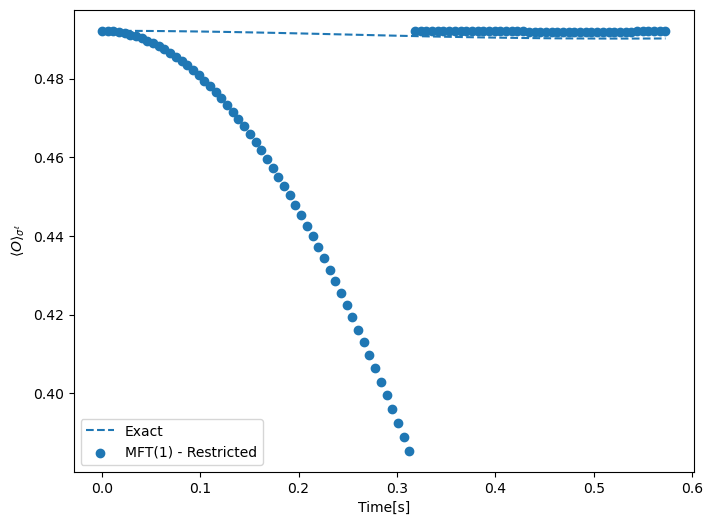

In [160]:
#obs1=spin_ops['sy'][2]*spin_ops['sy'][3]
obs=sz_total
sigma_maxent=[gij.safe_expm_and_normalize(K=Kti) for Kti in Kmaxent]
obs_evex=np.array([(rho*obs).tr() for rho in rhos_XYZ])
obs_maxent=np.array([(sigmat*obs).tr() for sigmat in sigma_maxent])

fig0,ax0=plt.subplots(figsize=(8,6))
list_of_colors_1=['r','g', 'b']

#Knorms=np.array([linalg.norm(Kex_ti- Kmaxent_ti) for Kex_ti, Kmaxent_ti in zip(resex_XY.states, Kmaxent)])

plt.plot(timespan, obs_evex, label='Exact', linestyle='dashed')
plt.scatter(timespan, obs_maxent, label=r'MFT(1) - Restricted')

#plt.plot(timespan, Knorms)

ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle O \rangle_{\sigma^\ell}$")
plt.show()